# 1. EFFECTIVENESS OF THE ONLINE LEARNING RULE

## Setup the environment

#### Adding the source code path

In [1]:
import sys  
sys.path.insert(1, './../../ESN-IP/IP/.')

In [2]:
import random

random.seed(10)

#### Import experiment data 

In [3]:
from DATA import NARMA10

data = NARMA(True, [40,10,50])

X_TR, Y_TR = data.TR()
X_VAL, Y_VAL = data.VAL()
X_TS, Y_TS = data.TS()

## NOT PRETRAINED RESERVOIR

In [ ]:
N_UNITS = 50

In [4]:
from IPReservoir import IPReservoir
from ESN import Reservoir
from IntrinsicPlasticity import IPMask

simple_reservoir = Reservoir(N = N_UNITS, sparsity=0.9, ro_rescale=0.25, bias = False)

W_x = simple_reservoir.W_x
W_u = simple_reservoir.W_u
b_x = simple_reservoir.b_x
b_u = simple_reservoir.b_u

## PRETRANING WITH OLD STYLE INTRINSIC PLASTICITY

In [5]:
ip_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.normalMask(N_UNITS), bias = True)

ip_reservoir.W_x = W_x
ip_reservoir.W_u = W_u
ip_reservoir.b_x = b_x
ip_reservoir.b_u = b_u

In [6]:
ip_reservoir.pre_train(X_TR, eta=-0.0000015, epochs=5,  learning_rule="online", verbose=True) #16

- Epoch: 1) | KL Divergence value: 1665.03759765625.
- Epoch: 2) | KL Divergence value: 1658.373291015625.
- Epoch: 3) | KL Divergence value: 1651.6866455078125.
- Epoch: 4) | KL Divergence value: 1644.9573974609375.
- Epoch: 5) | KL Divergence value: 1638.1793212890625.


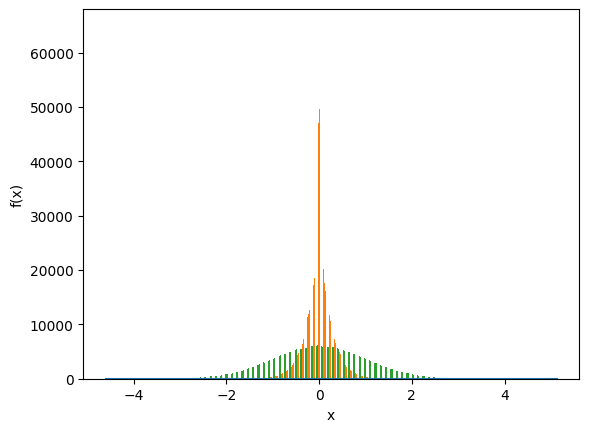

In [7]:
ip_reservoir.predict(X_TR, save_gradients=False, save_states=True)
ip_reservoir.plot_global_neural_activity()

In [8]:
ip_reservoir.predict(X_VAL, save_gradients=False, save_states=True)
ip_reservoir.sample_targets(X_VAL.shape[0], overwrite=True)

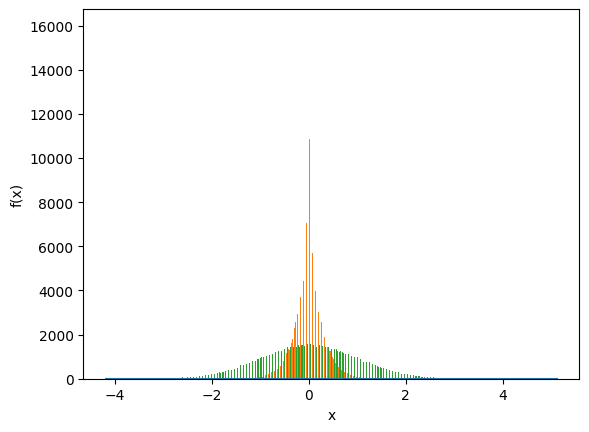

In [9]:
ip_reservoir.plot_global_neural_activity()

In [10]:
ip_reservoir.print_IP_stats([0,1])

Unit - (1): [ ACTUAL_MEAN == (0.11376022547483444)  ACTUAL_STD == (0.3870837092399597)][ TARGET_MEAN == (0.010230252519249916) TARGET_STD == (0.9924473762512207)]
Unit - (2): [ ACTUAL_MEAN == (-0.1462048441171646)  ACTUAL_STD == (0.4954724907875061)][ TARGET_MEAN == (0.008516531437635422) TARGET_STD == (0.9963817596435547)]
Overall network: [ACTUAL_MEAN == (-0.001539271674118936)  ACTUAL_STD == (0.2931402027606964)]


## BIMODAL MIXTURE OF GAUSSIAN

In [11]:
# It seems that switching the "old" bias terms down (input bias and recurrent weights bias), 
# helps the algorithm converging earlier, letting the IP bias dominate the linear translation. 

bimodal_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.mixedBimodalMask(N_UNITS), bias = False)

bimodal_reservoir.W_x = W_x
bimodal_reservoir.W_u = W_u
# bimodal_reservoir.b_x = b_x
# bimodal_reservoir.b_u = b_u

In [33]:
bimodal_reservoir.pre_train(X_TR, eta=-0.0000025, epochs=5,  learning_rule="online", verbose=True)

No transient applied. Reservoir was already warmed up
- Epoch: 1) | KL Divergence value: 1798.3768310546875.
- Epoch: 2) | KL Divergence value: 1744.673095703125.
- Epoch: 3) | KL Divergence value: 1700.475341796875.
- Epoch: 4) | KL Divergence value: 1664.63232421875.
- Epoch: 5) | KL Divergence value: 1636.1622314453125.


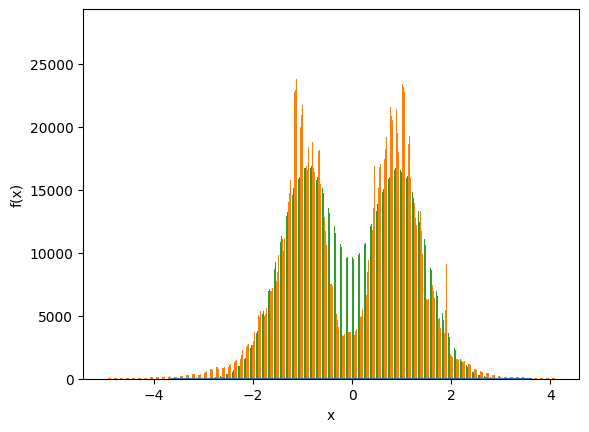

In [34]:
bimodal_reservoir.predict(X_TR, save_gradients=False, save_states=True)
bimodal_reservoir.plot_global_neural_activity()

In [35]:
bimodal_reservoir.predict(X_VAL, save_gradients=False, save_states=True)
bimodal_reservoir.sample_targets(X_VAL.shape[0], overwrite=True)

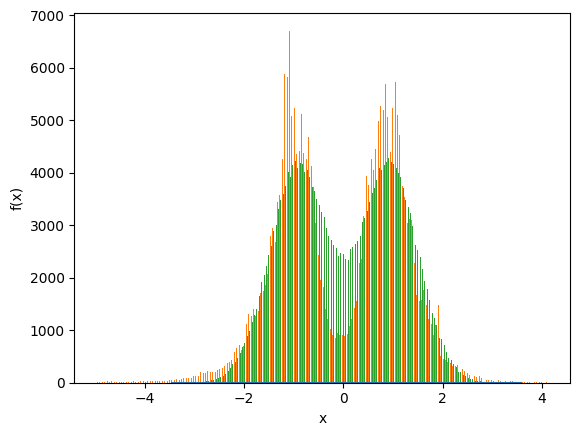

In [36]:
bimodal_reservoir.plot_global_neural_activity()

In [16]:
bimodal_reservoir.print_IP_stats([0,1])

Unit - (1): [ ACTUAL_MEAN == (0.13806243240833282)  ACTUAL_STD == (0.4184536933898926)][ TARGET_MEAN == (-0.913788378238678) TARGET_STD == (0.5809088349342346)]
Unit - (2): [ ACTUAL_MEAN == (-0.1842835545539856)  ACTUAL_STD == (0.5433576107025146)][ TARGET_MEAN == (0.9223214983940125) TARGET_STD == (0.5809535980224609)]
Overall network: [ACTUAL_MEAN == (-0.0008731913403607905)  ACTUAL_STD == (0.31919023394584656)]


## EVAUALTUION IN ESN

In [37]:
from ESN import EchoStateNetwork

simple_esn = EchoStateNetwork(simple_reservoir)
ip_esn = EchoStateNetwork(ip_reservoir)
bimodal_esn = EchoStateNetwork(bimodal_reservoir)

from Metrics import NRMSE, MSE

### HANDMADE UGLY LAMBDA SEARCH

No transient applied. Reservoir was already warmed up
torch.Size([8000])
NORMALIZED ROOT-MEAN SQUARE ERROR: 3.13277319114604e-06


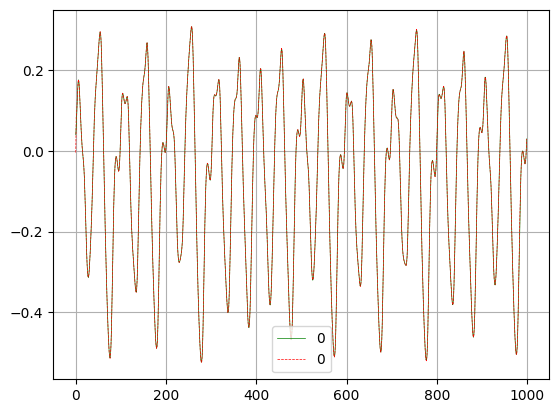

In [38]:
simple_esn.train(X_TR, Y_TR, 0)

#simple_esn.readout.predict(simple_esn.reservoir.predict(X_TR))

print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { simple_esn.evaluate(X_VAL, Y_VAL, metric=MSE(), plot=True)}" )

No transient applied. Reservoir was already warmed up
torch.Size([8000])
NORMALIZED ROOT-MEAN SQUARE ERROR: 3.4935929082693798e-06


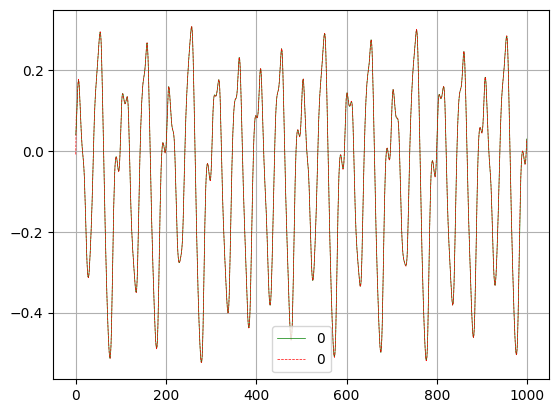

In [39]:

ip_esn.train(X_TR, Y_TR, 0)

print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { ip_esn.evaluate(X_VAL, Y_VAL, metric=MSE(), plot=True)}" )

No transient applied. Reservoir was already warmed up
torch.Size([8000])
NORMALIZED ROOT-MEAN SQUARE ERROR: 8.58598037074485e-06


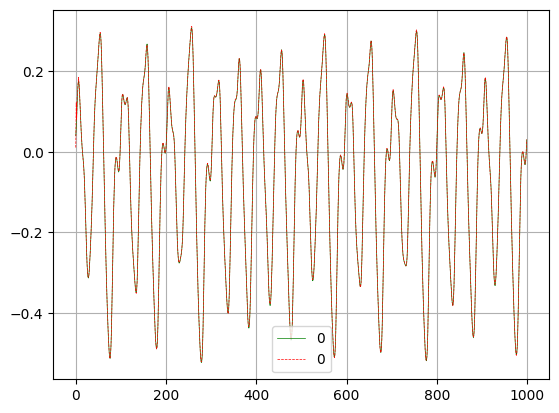

In [40]:
bimodal_esn.train(X_TR, Y_TR, 0)

print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { bimodal_esn.evaluate(X_VAL, Y_VAL, metric=MSE(), plot=True)}" )

### COMPARISON ON TEST DATA

NORMALIZED ROOT-MEAN SQUARE ERROR: 2.6289302642458424e-06


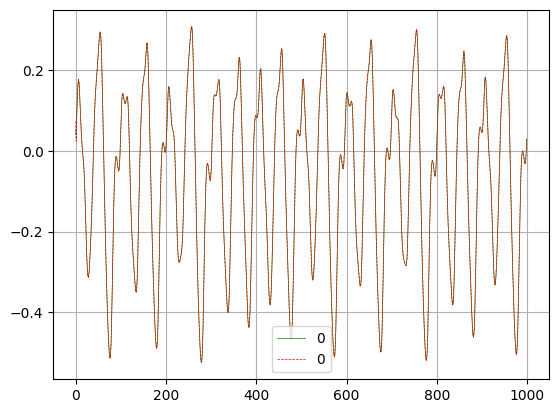

In [41]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { simple_esn.evaluate(X_TS, Y_TS, metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 3.106008144304466e-06


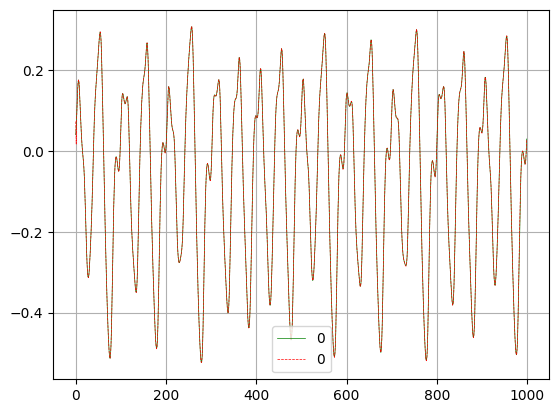

In [42]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { ip_esn.evaluate(X_TS, Y_TS, metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 5.438399668392323e-06


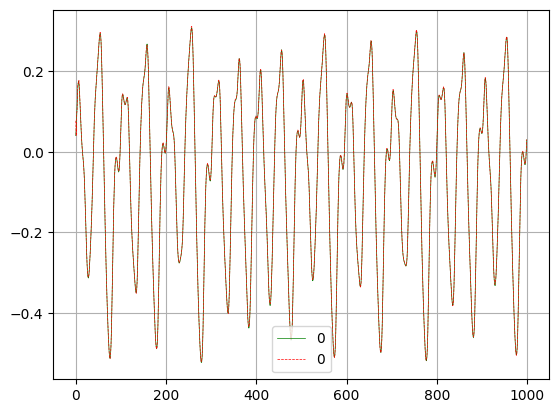

In [43]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { bimodal_esn.evaluate(X_TS, Y_TS, metric=MSE(), plot=True)}" )